What is MCMC? How do I use it? How do I write one?

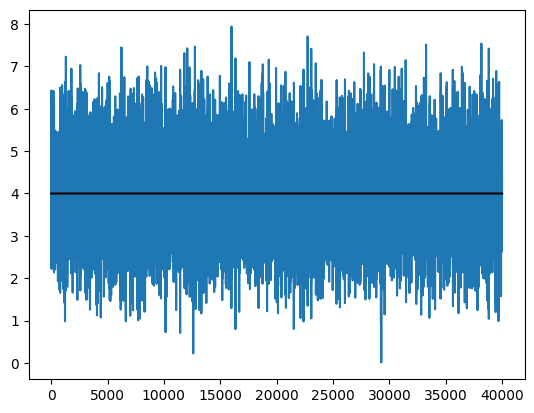

In [16]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from genjax.inference.smc import *
from genjax import ChoiceMapBuilder as C
from genjax._src.core.interpreters.incremental import Diff
from genjax import gen, GenericProblem, normal
from jax import jit

# We can first define a simple model using GenJAX.
@gen
def model(x):
    a = normal(0., 5.) @ "a"
    b = normal(0., 1.) @ "b"
    y = normal(a*x + b, 1.) @ "y"
    return y 

# Together with observations, this creates a posterior inference problem.
obs = C["y"].set(4.0)

# The key ingredient in MCMC is a transition kernel. 
# We can write it in GenJAX as a function that takes a current trace and returns a new trace.
# Let's write a simple Metropolis-Hastings (MH) kernel.
def metropolis_hastings_move(mh_args, subkey):
    # For now, we give the kernel the full state of the model, the proposal, and the observations.
    trace, model, proposal, proposal_args, observations = mh_args
    model_args = trace.get_args()
    
    # The core computation is updating a trace, and for that we will call the model's update method.
    # The update method takes a random key, a trace, and a GenericProblem object.
    # The former contains a pair of a Diff object for the arguments and a ChoiceMap of observations.
    argdiffs = Diff.tree_diff_no_change(model_args)
    proposal_args_forward = (trace, *proposal_args)
    
    # We sample the proposed changes to the trace.
    # This is encapsulated in a simple GenJAX generative function.
    fwd_choices, fwd_weight, _ = proposal.propose(subkey, proposal_args_forward)
    
    update = GenericProblem(argdiffs, fwd_choices)
    new_trace, weight, _, discard = model.update(subkey, trace, update)
    
    # Because we are using MH, we don't directly accept the new trace.
    # Instead, we compute a (log) acceptance ratio α and decide whether to accept the new trace, and otherwise keep the old one.
    proposal_args_backward = (new_trace, *proposal_args)
    bwd_weight, _ = proposal.assess(discard, proposal_args_backward)
    α = weight - fwd_weight + bwd_weight
    ret_fun = jax.lax.cond(jnp.log(jax.random.uniform(subkey)) < α,
                        lambda: new_trace,
                        lambda: trace)
    return (ret_fun, model, proposal, proposal_args, observations), ret_fun

# We define a simple proposal distribution for the changes in the trace using a Gaussian drift around the current value of "a".
@gen
def prop(tr, *_):
    orig_a = tr.get_choices()["a"]
    a = normal(orig_a, 1.) @ "a"
    return a

# The overall MH algorithm is a loop that repeatedly applies the MH kernel,
# which can conveniently be written using jax.lax.scan.
def mh(trace, model, proposal, proposal_args, observations, key, num_updates):
    mh_keys = jax.random.split(key, num_updates)
    last_carry, mh_chain = jax.lax.scan(metropolis_hastings_move, (trace, model, proposal, proposal_args, observations), mh_keys)
    return last_carry[0], mh_chain

# Our custom MH algorithm is a simple wrapper around the MH kernel using our chosen proposal distribution.
def custom_mh(trace, model, observations, key, num_updates):
    return mh(trace, model, prop, (), observations, key, num_updates)

# We now want to create a function run_inference that takes the inference problem, i.e. the model and observations, a random key, and returns traces from the posterior.
def run_inference(model, model_args, obs, key, num_samples):
    key, subkey1, subkey2 = jax.random.split(key, 3)
    # TODO: is that ok to ignore the weight?
    # We sample once from a default importance sampler to get an initial trace.
    tr, _ = model.importance(subkey1, obs, model_args)
    # We then run our custom Metropolis-Hastings kernel to rejuvenate the trace.
    rejuvenated_trace, mh_chain = custom_mh(tr, model, obs, subkey2, num_samples)
    return rejuvenated_trace, mh_chain 

# We add a little visualization function to validate the results.
def validate_mh(mh_chain):
    a = mh_chain.get_choices()["a"]
    b = mh_chain.get_choices()["b"]    
    y = mh_chain.get_retval()
    x = mh_chain.get_args()[0]
    plt.plot(range(len(y)), a*x + b)    
    plt.plot(range(len(y)), y, color='k')
    plt.show()
    
# Testing the inference function.
key = jax.random.PRNGKey(5000)
model_args = (5.,)
num_samples = 40000
_, mh_chain = run_inference(model, model_args, obs, key, num_samples)
validate_mh(mh_chain)